<a href="https://colab.research.google.com/github/JG-geek/Diffusion_Models/blob/main/deblurring_using_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## setup and imports

In [8]:
%pip install -q diffusers

In [34]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## load dataset

In [10]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([0, 1, 6, 8, 3, 4, 6, 3])


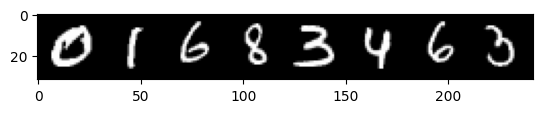

In [13]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
images, labels = next(iter(train_dataloader))
print('Input shape:', images.shape)
print('Labels:', labels)
plt.imshow(torchvision.utils.make_grid(images)[0], cmap='grey');

## UNet2DModel
(from diffusers library)

In [14]:
model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1,
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

In [17]:
## sanity check
model.to(device)
input = torch.randn(8, 1, 28, 28).to(device)
output = model(input, 0)
print('Output shape:', output.sample.shape)

Output shape: torch.Size([8, 1, 28, 28])


## corrrupt the data

In [18]:
import numpy as np
import cv2  # OpenCV for image blurring

def smooth_gaussian(image, kernel_size=5, iterations=3):
    """
    Apply Gaussian blurring multiple times to smooth the image more aggressively.

    Parameters:
    - image: Input image tensor of shape (1, H, W).
    - kernel_size: Size of the Gaussian kernel.
    - iterations: Number of times to apply the blur.

    Returns:
    - Smoothed image tensor of shape (1, H, W).
    """
    image_np = image.cpu().numpy().squeeze()  # Move to CPU before converting
    for _ in range(iterations):  # Apply multiple blurring passes
        image_np = cv2.GaussianBlur(image_np, (kernel_size, kernel_size), 0)
    return torch.tensor(image_np).unsqueeze(0).to(image.device)  # Convert back to tensor and move to original device

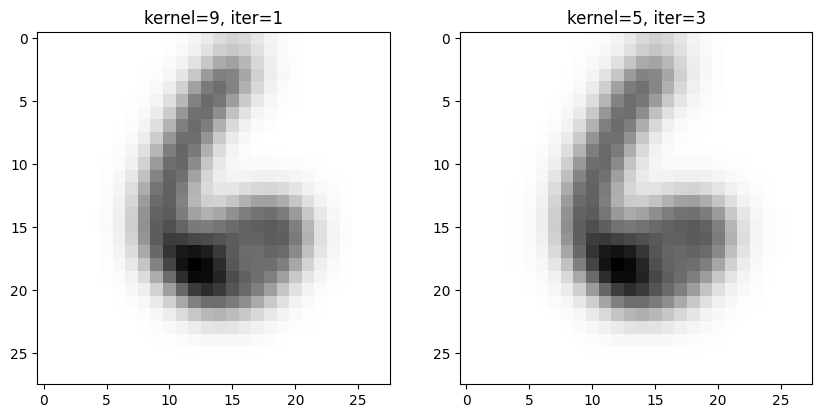

In [32]:
smoothed_image = smooth_gaussian(images[6], 9, 1)
smoothed_image2 = smooth_gaussian(images[6], 5, 3)
# show 2 images side by side
# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(smoothed_image.cpu().squeeze(), cmap='Greys')
axes[0].set_title('kernel=9, iter=1')

axes[1].imshow(smoothed_image2.cpu().squeeze(), cmap='Greys')
axes[1].set_title('kernel=5, iter=3')

plt.show()

In [ ]:
#@markdown Training loop (10 Epochs):

# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our network
model.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)

        blurred_x = torch.stack([smooth_gaussian(img,5,3) for img in x])
        blurred_x = blurred_x.to(device)

        # noise = torch.randn_like(x)
        # timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        # noisy_x = noise_scheduler.add_noise(x, noise, timestep)

        # Get the model prediction
        pred = model(blurred_x, 0).sample # using timestep = 0 always

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the input

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

 46%|████▌     | 214/469 [00:51<01:00,  4.21it/s]